# **Introdução**

Este código faz parte de uma das etapas do processo seletivo de estágio da VExpenses. O objetivo é comparar diferentes técnicas de aprendizado de máquina que preveem se um usuário de um site imobiliário irá ou não comprar uma casa. Isto será feito a partir de um [dataset](https://github.com/yurifernandes96/house_buying_prediction/blob/main/src/Dataset.csv) que conta com diferentes atributos relacionados aos usuários do site, tais como renda anual, tempo em que navegou pelo site, entre outros.

# **Bibliotecas**

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# **Preparação dos dados**

## Carregamento

In [131]:
dados = pd.read_csv('https://raw.githubusercontent.com/yurifernandes96/house_buying_prediction/refs/heads/main/src/Dataset.csv')
print(dados.shape)
dados.head()

(200, 6)


,Idade,Renda Anual (em $),Gênero,Tempo no Site (min),Anúncio Clicado,Compra (0 ou 1)
0,29.0,30000.0,Feminino,5.741706,Não,0
1,58.0,50000.0,Feminino,21.885505,Sim,0
2,50.0,70000.0,Feminino,6.121339,Não,1
3,21.0,100000.0,Feminino,16.264925,Não,0
4,59.0,50000.0,Feminino,28.235667,Sim,1


In [132]:
# Renomeando as colunas para simplificar a análise
dados.columns = ['Idade', 'Renda', 'Gênero', 'Tempo_Site', 'Anúncio_Clicado', 'Comprou']

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Idade            190 non-null    float64
 1   Renda            189 non-null    float64
 2   Gênero           193 non-null    object 
 3   Tempo_Site       200 non-null    float64
 4   Anúncio_Clicado  190 non-null    object 
 5   Comprou          200 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 9.5+ KB


Existem colunas com valores nulos que devem ser tratados, faremos um tratamento individualizado para cada coluna, a partir de uma análise da distribuição dos seus dados.

## Idade

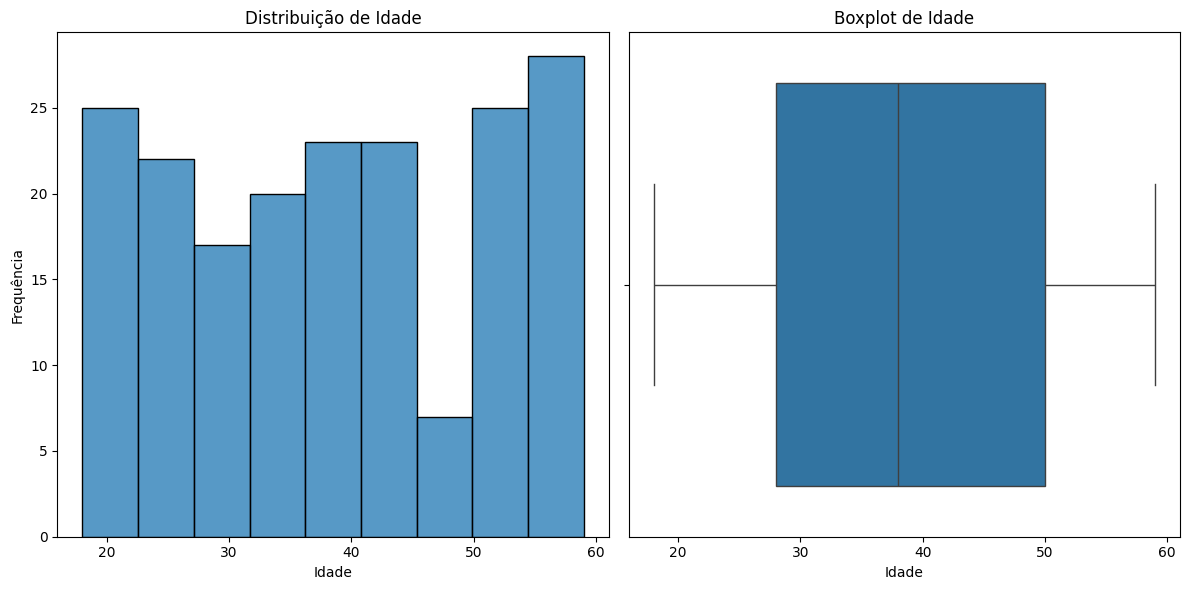

In [133]:
# Configura o tamanho da figura e cria os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma
sns.histplot(data=dados['Idade'].dropna(), kde=False, ax=axes[0])
axes[0].set_title('Distribuição de Idade')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Frequência')

# Boxplot
sns.boxplot(data=dados['Idade'].dropna(), orient='h', ax=axes[1])
axes[1].set_title('Boxplot de Idade')
axes[1].set_xlabel('Idade')

plt.tight_layout()
plt.show()

O histograma e o boxplot das idades mostrou valores condizentes com o esperado, não havendo nenhum valor discrepante (outlier) e nenhuma idade com concentração de usuários muito maior do que as demais.

Como visto anteriormente com o método "info", existem 10 valores nulos na coluna idade. Por se tratar de um dataset de apenas 200 usuários, esses 10 usuários com idade faltante são significativos demais para serem simplesmente descartados. Então escolhemos por preencher os valores nulos de idade com a **mediana** de todas as idades.

In [134]:
# Preenchendo os valores nulos com a mediana
mediana_idades = dados['Idade'].median()
dados.fillna({'Idade': mediana_idades}, inplace=True)

## Renda

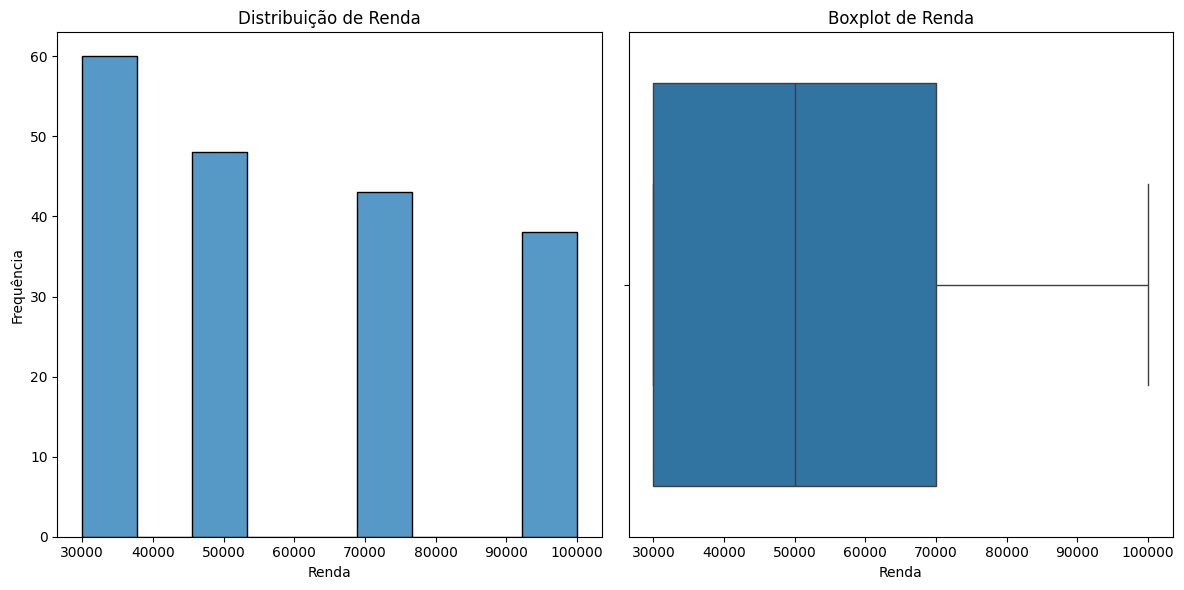

In [135]:
# Configura o tamanho da figura e cria os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma
sns.histplot(data=dados['Renda'].dropna(), kde=False, ax=axes[0])
axes[0].set_title('Distribuição de Renda')
axes[0].set_xlabel('Renda')
axes[0].set_ylabel('Frequência')

# Boxplot
sns.boxplot(data=dados['Renda'].dropna(), orient='h', ax=axes[1])
axes[1].set_title('Boxplot de Renda')
axes[1].set_xlabel('Renda')

plt.tight_layout()
plt.show()

Embora pareça ser uma variável categórica (só assume valores 30000, 50000, 70000 ou 100000), por conhecimento de domínio sabemos que 'Renda' é uma variável contínua. Então não havendo nenhum outlier, optamos por substituir os valores nulos pela **média** das rendas anuais dos demais usuários.

In [136]:
media_rendas = dados['Renda'].mean()
dados.fillna({'Renda': media_rendas}, inplace=True)

## Gênero

Por experiência de domínio, devemos analisar se a coluna 'Gênero' exerce de fato algum impacto na variável 'Comprou', levando em conta que o sexo de uma pessoa não deveria impactar na sua decisão de comprar ou não uma casa.

Inicialmente, vamos visualizar a distribuição da varíavel "Comprou" independente do gênero do usuário para então compará-la com a sua distribuição dentro de cada gênero.

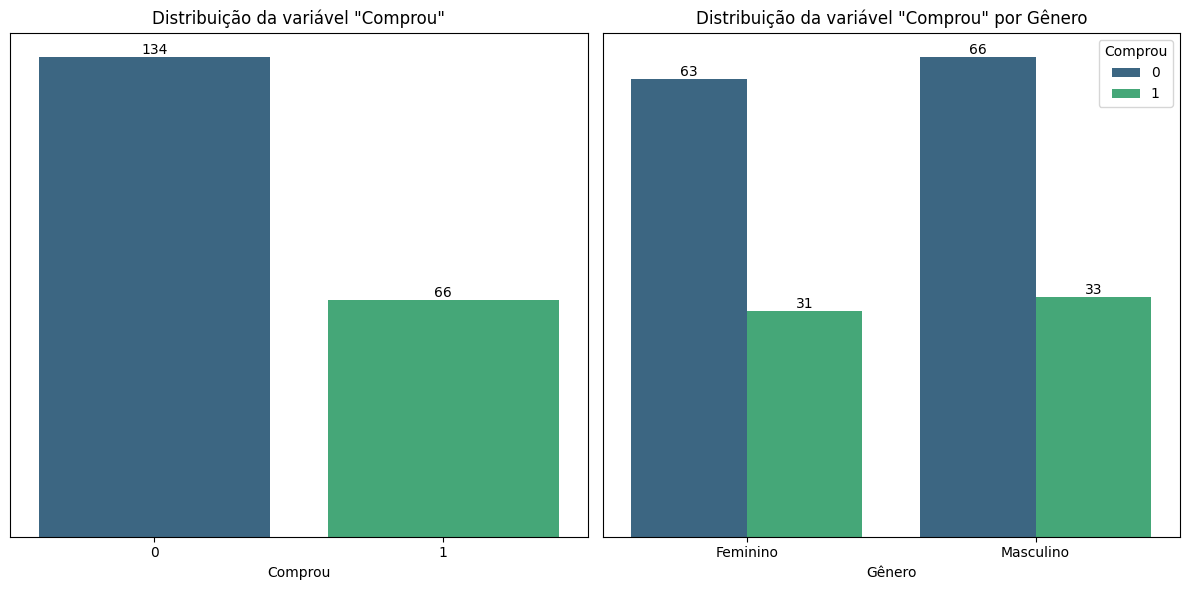

In [137]:
# Configura o tamanho da figura e cria os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Distribuição da variável "Comprou" independente do gênero
sns.countplot(data=dados, x='Comprou', hue='Comprou', palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Distribuição da variável "Comprou"')
axes[0].get_yaxis().set_visible(False)
for container in axes[0].containers:
    axes[0].bar_label(container)

# Distribuição da variável "Comprou" em cada gênero
sns.countplot(data=dados, x='Gênero', hue='Comprou', palette='viridis', ax=axes[1])
axes[1].get_yaxis().set_visible(False)
for container in axes[1].containers: # posiciona valores no topo das barras
    axes[1].bar_label(container)
plt.title('Distribuição da variável "Comprou" por Gênero')
plt.xlabel('Gênero')

plt.tight_layout()
plt.show()

Podemos identificar que a variável "Gênero" não exerce impacto algum em "Comprou", uma vez que a proporção de pessoas que compram uma casa é praticamente a mesma independente do gênero.

In [138]:
# Remove a coluna "Gênero"
dados.drop('Gênero', axis=1, inplace=True)

## Tempo no site

Embora não haja valores nulos na variável "Tempo_Site", ainda assim devemos analisar a distribuição de seus valores em busca de outliers.

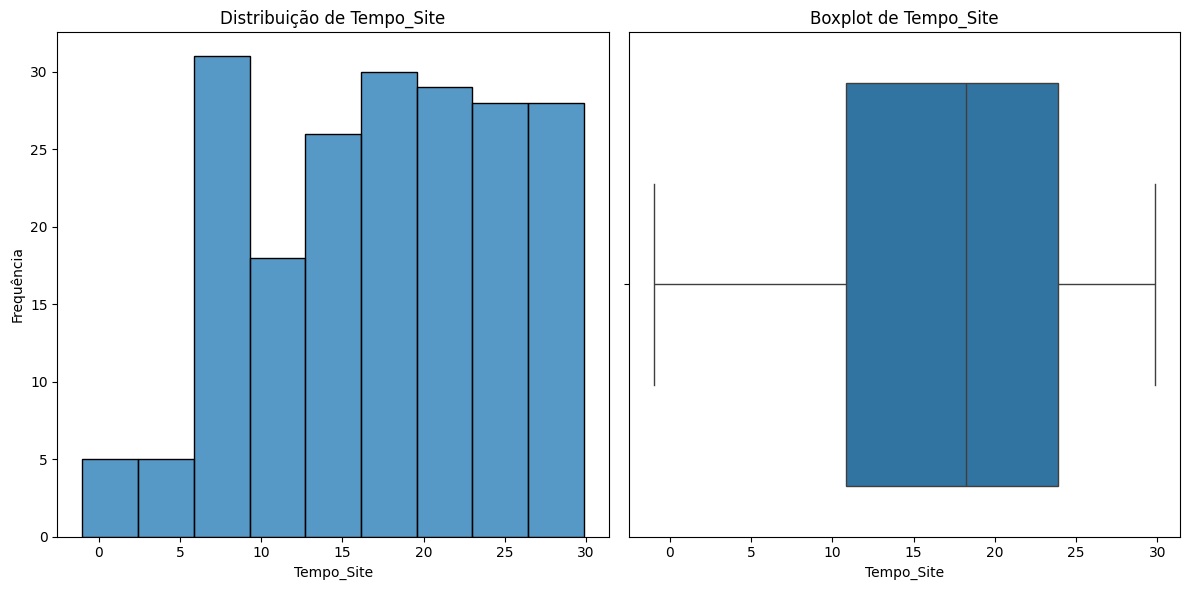

In [139]:
# Configura o tamanho da figura e cria os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma
sns.histplot(data=dados['Tempo_Site'], kde=False, ax=axes[0])
axes[0].set_title('Distribuição de Tempo_Site')
axes[0].set_xlabel('Tempo_Site')
axes[0].set_ylabel('Frequência')

# Boxplot
sns.boxplot(data=dados['Tempo_Site'], orient='h', ax=axes[1])
axes[1].set_title('Boxplot de Tempo_Site')
axes[1].set_xlabel('Tempo_Site')

plt.tight_layout()
plt.show()

Pela análise do histograma e do boxplot, notamos que existem valores negativos que são incoerentes com a realidade.

In [140]:
dados[dados['Tempo_Site'] < 0]

,Idade,Renda,Tempo_Site,Anúncio_Clicado,Comprou
107,38.0,50000.000000,-1.0,Sim,0
116,40.0,30000.000000,-1.0,Sim,0
132,38.0,50000.000000,-1.0,NaN,0
133,20.0,58253.968254,-1.0,Sim,0
147,54.0,70000.000000,-1.0,Sim,1


Os valores negativos são todos -1. Provavelmente isso indica que não foi possível computar o tempo que o usuário permaneceu no site. Vamos substituir os valores -1 pela **média** de Tempo_Site.

In [141]:
# Calcula a média de "Tempo_Site" descartando os valores -1
media_tempo_site = dados[dados['Tempo_Site'] > 0]['Tempo_Site'].mean()

# Atribui a média calculada nos usuários em que Tempo_Site == -1
dados.loc[dados['Tempo_Site'] < 0, 'Tempo_Site'] = media_tempo_site

# Checando se deu certo
dados.iloc[[107, 116, 132, 133, 147]]

,Idade,Renda,Tempo_Site,Anúncio_Clicado,Comprou
107,38.0,50000.000000,17.81958,Sim,0
116,40.0,30000.000000,17.81958,Sim,0
132,38.0,50000.000000,17.81958,NaN,0
133,20.0,58253.968254,17.81958,Sim,0
147,54.0,70000.000000,17.81958,Sim,1


## Anúncio clicado

Conforme visto pelo método "info", existem 10 valores nulos para a variável "Anúncio_clicado". Por se tratar de uma variável binária, uma alternativa para corrigir os valores nulos seria substituí-los pela moda da coluna, desde que haja uma distribuição muito desigual entre os dois valores.

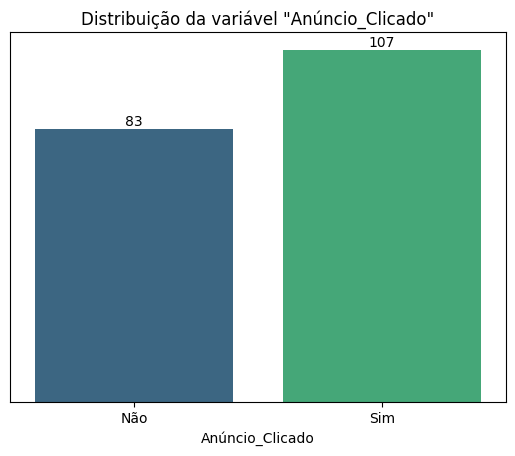

In [142]:
# Distribuição de "Anúncio_Clicado"
ax = sns.countplot(data=dados, x='Anúncio_Clicado', hue='Anúncio_Clicado', palette='viridis', legend=False)
ax.get_yaxis().set_visible(False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribuição da variável "Anúncio_Clicado"')
plt.show()

O gráfico mostra que não há uma distribuição tão desigual assim para simplesmente atribuirmos "Sim" aos valores faltantes. Portanto, optamos por remover os usuários em que "Anúncio_clicado" for nulo.

Além disso, devemos mapear os textos (Sim/Não) para valores numéricos (1/0), que são úteis para o modelo.

In [143]:
# Remove usuários em que 'Anúncio_Clicado' == NULL
dados.dropna(subset=['Anúncio_Clicado'], inplace=True)

# Conversão Sim/Não -> 1/0
dados['Anúncio_Clicado'] = dados['Anúncio_Clicado'].map(lambda x: 1 if x == 'Sim' else 0)

## Colunas redundantes

Existe a possibilidade de duas ou mais variáveis possuírem uma correlação forte entre si. Por exemplo, é possível que neste dataset quanto maior a idade do usuário, maior a sua renda anual, tratando-se de uma correlação forte e positiva. Isso faz com que uma das variáveis (Idade ou Renda) se torne irrelevante para o modelo, devendo ser descartada.

Para avaliar a correlação entre duas variáveis contínuas, é utilizada a correlação de Pearson. Já para avaliar a correlação entre uma variável contínua e outra binária, é utilizada a correlação ponto-bisseral, que nada mais é do que uma variação da correlação de Pearson.

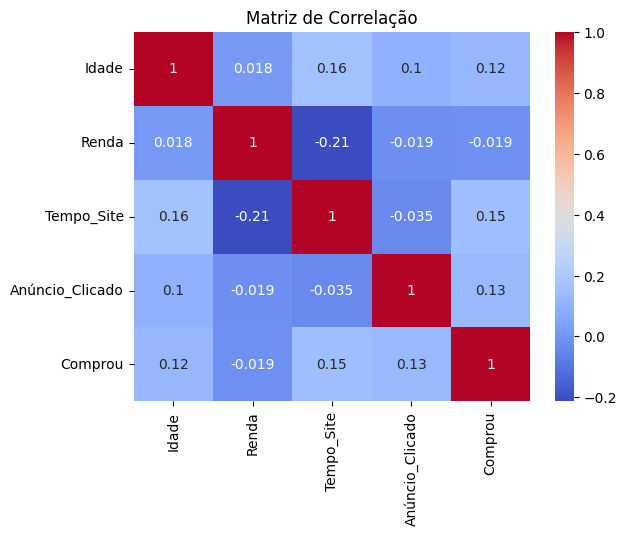

In [144]:
# Matriz de correlação
corr_matrix = dados.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

A matriz de correlação mostra que nenhum par de variáveis possui correlação forte entre si. Sendo asssim, manteremos todas variáveis no dataset.

## Dataset pronto

In [145]:
dados.to_csv('Dataset_Limpo.csv', index=False)

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Idade            190 non-null    float64
 1   Renda            190 non-null    float64
 2   Tempo_Site       190 non-null    float64
 3   Anúncio_Clicado  190 non-null    int64  
 4   Comprou          190 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 8.9 KB


## Conjuntos de treino e teste

Para treinamento e teste dos nossos modelos, iremos separar 70% das amostras para o conjunto de treino e o restante (30%) para o conjunto de teste.

In [146]:
# Separando variáveis preditoras (X) e alvo (y)
X = dados.drop(columns=['Comprou'])
y = dados['Comprou']

# Dividindo os dados em conjuntos de treino (70%) e teste (30%)
'''Note que devemos usar o parâmetro stratify=y devido ao desbalanceamento das classes
na variável 'Comprou'. Graças a este parâmetro, podemos manter a mesma proporção de 1/0
tanto no conjunto de treino quanto no conjunto de teste.'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# **Regressão Logística**

A regressão logística é um método popular para prever uma resposta categórica. É um caso especial de modelos Lineares Generalizados que prevê a probabilidade dos resultados. A regressão logística pode ser usada para prever um resultado binário usando regressão logística binomial ou pode ser usada para prever um resultado multiclasse usando regressão logística multinomial.

<font size=2>**Fonte:** [Medium](https://medium.com/@nara.guimaraes/regress%C3%A3o-log%C3%ADstica-como-usu%C3%A1-la-em-an%C3%A1lise-de-dados-3fdb6be3a255)</font>

In [147]:
# Criando e treinando o modelo de regressão logística
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Realizando predições no conjunto de teste
y_pred = lr.predict(X_test)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.6667
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        39
           1       0.33      0.06      0.10        18

    accuracy                           0.67        57
   macro avg       0.51      0.50      0.45        57
weighted avg       0.57      0.67      0.57        57



Uma métrica muito importante neste problema é a quantidade de falsos-negativos, ou seja, a quantidade de usuários que pretendem comprar uma casa mas que o modelo previu que não vão comprar. Para este problema, queremos encontar um modelo em que este valor seja o menor possível.

Na prática, buscamos um modelo com a maior proporção de verdadeiros-positivos (recall da classe 1), pois isso significa que a taxa de falsos-negativos é menor.

In [148]:
# Armazena o recall da classe 1 para cada modelo
recall_c1 = []

# Armazena a influencia que cada feature exerce em cada modelo
influencia_features = pd.DataFrame(columns=['Modelo', 'Idade', 'Renda', 'Tempo_Site', 'Anúncio_Clicado'])

In [149]:
# Facilita a leitura da matriz de confusão e retorna o recall da classe 1
def matriz_de_confusao(y_test, y_pred):
  m = confusion_matrix(y_test, y_pred)
  print(' '*27, 'Previsto')
  print(' '*18, 'Não-Comprou', ' '*5 ,'Comprou')
  print(' '*4, 'Não-Comprou', ' '*6, f"{int(m[0][0]):2d}", ' '*12, f"{int(m[0][1]):2d}")
  print('Real')
  print(' '*8, 'Comprou', ' '*6, f"{int(m[1][0]):2d}", ' '*12, f"{int(m[1][1]):2d}")

  recall_c1 = m[1][1]/(m[1][0] + m[1][1])
  return recall_c1

In [150]:
# Armazena a influencia de cada feature na Regressão Logística
influencia_features.loc[len(influencia_features)] = ['0 - Regressão Logística'] + list(lr.coef_[0])

# Matriz de confusão para a Regressão Logística
recall_c1.append(matriz_de_confusao(y_test, y_pred))

                            Previsto
                   Não-Comprou       Comprou
     Não-Comprou        37               2
Real
         Comprou        17               1


Para este modelo, dos 18 usuários do conjunto de teste que compraram uma casa, o modelo previu corretamente apenas 1 deles, resultando em um recall de 6%.

# **Árvore de Decisão**

Uma árvore de decisão é uma estrutura gráfica hierárquica que lhe ajuda a examinar atentamente e a classificar precisamente um modelo. O conceito de árvore de decisão é selecionar splits que diminuem a impureza da distribuição de classes nos subconjuntos de instâncias resultantes.

<font size=2>**Fonte:** [IBM](https://www.ibm.com/docs/pt-br/db2/12.1?topic=building-decision-trees)</font>

In [151]:
# Cria e treina a árvore de decisão
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = dt.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.5965
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        39
           1       0.41      0.61      0.49        18

    accuracy                           0.60        57
   macro avg       0.59      0.60      0.58        57
weighted avg       0.65      0.60      0.61        57



In [152]:
# Armazena a influencia de cada feature na Árvore de Decisão
influencia_features.loc[len(influencia_features)] = ['2 - Árvore de Decisão'] + list(dt.feature_importances_)

# Matriz de confusão para a Árvore de Decisão
recall_c1.append(matriz_de_confusao(y_test, y_pred))

                            Previsto
                   Não-Comprou       Comprou
     Não-Comprou        23              16
Real
         Comprou         7              11


Para este modelo, dos 18 usuários do conjunto de teste que compraram uma casa, o modelo previu corretamente 11 deles, resultando em um recall 61%.

# **Random Forest**

O Random Forest nada mais é do que a criação de várias árvores de decisão, de maneira aleatória, formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final, em uma espécie de votação.

Com o modelo de machine learning devidamente criado, podemos apresentar novos dados e obter o resultado da previsão. Cada árvore criada irá apresentar o seu resultado, sendo que em problemas de regressão será realizada a média dos valores previstos, e esta média informada como resultado final, e em problemas de classificação o resultado que mais vezes foi apresentado será o escolhido.

<font size=2>**Fonte:** [Didática Tech](https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/)</font>

In [153]:
# Cria e treina o modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.5439
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68        39
           1       0.25      0.22      0.24        18

    accuracy                           0.54        57
   macro avg       0.45      0.46      0.46        57
weighted avg       0.53      0.54      0.54        57



In [154]:
# Armazena a influencia de cada feature no Random Forest
influencia_features.loc[len(influencia_features)] = ['4 - Random Forest'] + list(rf.feature_importances_)

# Matriz de confusão para o Random Forest
recall_c1.append(matriz_de_confusao(y_test, y_pred))

                            Previsto
                   Não-Comprou       Comprou
     Não-Comprou        27              12
Real
         Comprou        14               4


Para este modelo, dos 18 usuários do conjunto de teste que compraram uma casa, o modelo previu corretamente apenas 4 deles, resultando em um recall 22%.

# **Otimização**

Uma tarefa importante em modelagens de machine learning é a melhoria do modelo através da otimização dos seus hiperparâmetros. Neste problema, iremos utilizar a técnica Grid Search, que consiste em encontrar o melhor modelo possível após testar a combinação de todos os valores de hiperparâmetros que é fornecido.

Além disso, iremos aplicar a técnica de Cross Validation, que consiste em dividir o conjunto de treino em k dobras (folds) e fazer k iterações neste conjunto. A cada iteração, um dos folds é separado dos demais e será utilizado para validação dos parâmetros. Ao final das iterações, os melhores parâmetros são selecionados e o modelo pode ser avaliado com o conjunto de teste.

 <img src="https://raw.githubusercontent.com/yurifernandes96/churn_prediction/refs/heads/main/imgs/grid_search_cross_validation.png">

## **Regressão Logística Otimizada**

In [155]:
# Criando e treinando o modelo de regressão logística
lr_cv = LogisticRegression(max_iter=1000, random_state=42)
lr_cv.fit(X_train, y_train)

# Definição do espaço de hiperparâmetros para otimização
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear'], # solver adequado para datasets pequenos
    'class_weight': [None, 'balanced']
}

# Configuração do Grid Search com validação cruzada (3 folds)
grid_search = GridSearchCV(
    estimator=lr_cv,
    param_grid=param_grid,
    scoring='recall',
    cv=3,  # Número de folds
)

# Treinando o modelo com o conjunto de treino
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.4561
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.31      0.44        39
           1       0.34      0.78      0.47        18

    accuracy                           0.46        57
   macro avg       0.55      0.54      0.46        57
weighted avg       0.62      0.46      0.45        57



In [156]:
# Armazena a influencia de cada feature na Regressão Logística Otimizada
influencia_features.loc[len(influencia_features)] = ['1 - Regressão Logística Otimizada'] + list(best_model.coef_[0])

# Matriz de confusão para Regressão Logística Otimizada
recall_c1.append(matriz_de_confusao(y_test, y_pred))

                            Previsto
                   Não-Comprou       Comprou
     Não-Comprou        12              27
Real
         Comprou         4              14


Para este modelo, dos 18 usuários do conjunto de teste que compraram uma casa, o modelo previu corretamente 14 deles, resultando em um recall 78%.

Ainda que o número de compradores inexistentes (falsos-positivos) tenha aumentado, pode-se considerar que o modelo teve uma melhora significativa, se, por exemplo, o objetivo do site é realizar uma campanha de marketing para compradores potenciais. Parte dos usuários alvo dessa campanha acabará sendo usuários não-compradores, mas o modelo garante que a maioria dos usuários compradores serão atingidos pela campanha.

## **Árvore de Decisão Otimizada**

In [157]:
# Definição do modelo de Decision Tree
dt_cv = DecisionTreeClassifier(random_state=42)

# Definição do espaço de hiperparâmetros para otimização
param_grid = {
    'max_depth': [2, 3, 5],
    'max_features': [2, 3, 4],
    'class_weight': [None, 'balanced']
}

# Configuração do Grid Search com validação cruzada (3 folds)
grid_search = GridSearchCV(
    estimator=dt_cv,
    param_grid=param_grid,
    scoring='recall',
    cv=3,  # Número de folds
)

# Treinando o modelo com o conjunto de treino
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.4912
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.31      0.45        39
           1       0.37      0.89      0.52        18

    accuracy                           0.49        57
   macro avg       0.61      0.60      0.49        57
weighted avg       0.70      0.49      0.48        57



In [158]:
# Armazena a influencia de cada feature na Árvore de Decisão Otimizada
influencia_features.loc[len(influencia_features)] = ['3 - Árvore de Decisão Otimizada'] + list(best_model.feature_importances_)

# Matriz de confusão para Árvore de Decisão Otimizada
recall_c1.append(matriz_de_confusao(y_test, y_pred))

                            Previsto
                   Não-Comprou       Comprou
     Não-Comprou        12              27
Real
         Comprou         2              16


Para este modelo, dos 18 usuários do conjunto de teste que compraram uma casa, o modelo previu corretamente 16 deles, resultando em um recall 89%.

## **Random Forest Otimizado**

In [159]:
# Definição do modelo de Random Forest
rf_cv = RandomForestClassifier(random_state=42)

# Definição do espaço de hiperparâmetros para otimização
param_grid = {
    'max_depth': [2, 3, 5],
    'max_features': [2, 3, 4],
    'class_weight': [None, 'balanced'],
    'n_estimators': [5, 10, 20] # número de árvores
}

# Configuração do Grid Search com validação cruzada (3 folds)
grid_search = GridSearchCV(
    estimator=rf_cv,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
)

grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.4737
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        39
           1       0.33      0.67      0.44        18

    accuracy                           0.47        57
   macro avg       0.52      0.53      0.47        57
weighted avg       0.59      0.47      0.48        57



In [160]:
# Armazena a influencia de cada feature no Random Forest Otimizado
influencia_features.loc[len(influencia_features)] = ['5 - Random Forest Otimizado'] + list(best_model.feature_importances_)

# Matriz de confusão para Random Forest Otimizado
recall_c1.append(matriz_de_confusao(y_test, y_pred))

                            Previsto
                   Não-Comprou       Comprou
     Não-Comprou        15              24
Real
         Comprou         6              12


Para este modelo, dos 18 usuários do conjunto de teste que compraram uma casa, o modelo previu corretamente 12 deles, resultando em um recall de 67%.

# **Resultados**

## Influencia de cada feature na decisão do modelo

In [161]:
influencia_features.sort_values(by='Modelo', ignore_index=True)

,Modelo,Idade,Renda,Tempo_Site,Anúncio_Clicado
0,0 - Regressão Logística,0.013296,0.000004,0.061570,0.669288
1,1 - Regressão Logística Otimizada,0.000000,-0.000004,0.018581,0.000000
2,2 - Árvore de Decisão,0.289583,0.168878,0.488650,0.052890
3,3 - Árvore de Decisão Otimizada,0.000000,0.070399,0.929601,0.000000
4,4 - Random Forest,0.339279,0.113105,0.490964,0.056653
5,5 - Random Forest Otimizado,0.176420,0.016720,0.735113,0.071748


Para a regressão logística, o valor em cada feature diz respeito ao coeficiente associado àquela variável. Quanto maior o coeficiente, maior a influência que aquela variável exerce na decisão do modelo. Pelo dataframe, nota-se que o primeiro modelo de regressão logística foi mais influenciado por "Anúncio_Clicado", enquanto que o modelo otimizado foi mais influenciado por "Tempo_Site".

Já para os modelos baseados em árvore, o valor em cada feature é um indicador do quanto aquela variável contribuiu para o ganho de informação ao se dividir um nó e o somatório da contribuição de cada variável deve ser 1 (100%). Tanto na árvore de decisão quanto no random forest o primeiro modelo foi mais influenciado por "Tempo_Site" e passou a ser ainda mais influenciado por "Tempo_Site" após a otimização.

Os valores obtidos no dataframe indicam que o **tempo** que um usuário passa navegando pelo site é o fator mais importante para o modelo decidir se ele vai ou não comprar uma casa.

## Desempenho de cada modelo antes e depois da otimização

A aplicação de técnicas de otimização de hiperparâmetros, combinada com o Cross Validation, resultou em um aumento de performance para os três modelos, considerando que a métrica mais importante nesse problema é o **recall da classe 1**.

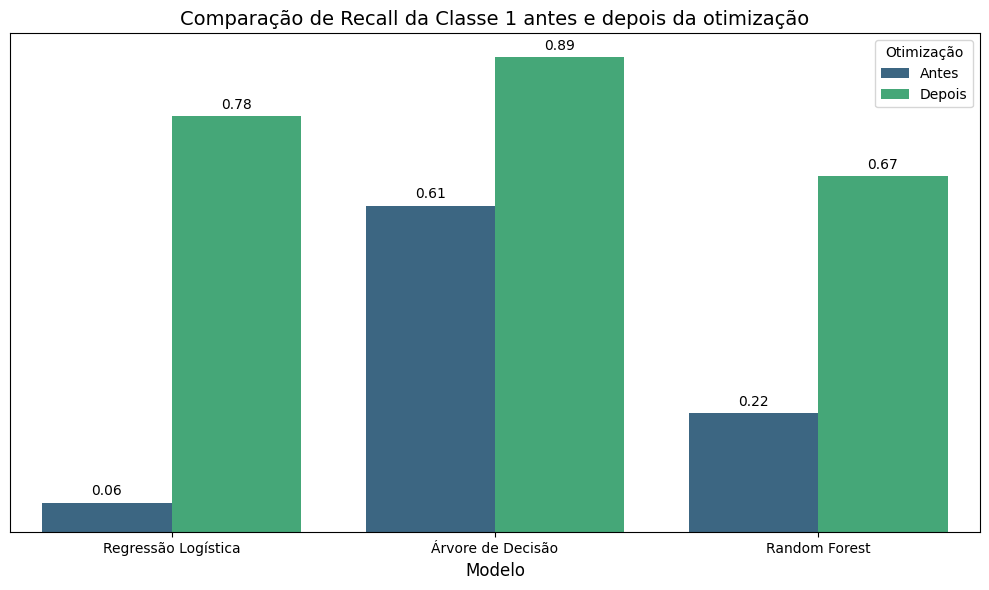

In [162]:
# Reorganiza a lista de recall para ficar antes/depois de cada otimização de modelo
recall_organizado = []
for i in range(3):
  recall_organizado.append(recall_c1[i])
  recall_organizado.append(recall_c1[i+3])

# Dicionário para plotagem dos valores
data = {
    'Modelo': [
        'Regressão Logística', 'Regressão Logística',
        'Árvore de Decisão', 'Árvore de Decisão',
        'Random Forest', 'Random Forest'
    ],
    'Otimização': ['Antes', 'Depois', 'Antes', 'Depois', 'Antes', 'Depois'],
    'Recall': recall_organizado
}

# Cria um DataFrame
df = pd.DataFrame(data)

# Cria o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Modelo', y='Recall', hue='Otimização', palette='viridis')
ax.get_yaxis().set_visible(False)

# Adiciona rótulos e título
plt.title('Comparação de Recall da Classe 1 antes e depois da otimização', fontsize=14)
plt.xlabel('Modelo', fontsize=12)

# Posiciona valores no topo das barras
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

# Exibir o gráfico
plt.tight_layout()
plt.show()

O gráfico de comparação de modelos antes/depois da otimização mostra que a Árvore de Decisão Otimizada é o modelo com melhor performance para este dataset, com um recall de 89% para a classe 1. Isso significa que de cada 100 usuários que vão comprar uma casa, o modelo é capaz de identificar 89 deles, favorecendo, por exemplo, campanhas de marketing e propaganda a alcançar a maioria dos usuários-alvo.